In [1]:
import jcopdl, luwiji
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
device

device(type='cpu')

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
bs = 20
crop_size = 64

#data train dengan augmentasi
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size,scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
#data test tanpa augmentasi
test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data3/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data3/test/", transform=test_transform)
testloader = DataLoader(test_set,batch_size=bs, shuffle=True)

In [5]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([20, 3, 64, 64])

In [6]:
label2cat = train_set.classes
label2cat

['Crinivirus', 'Curly_top', 'healthy', 'layu']

In [7]:
from jcopdl.layers import conv_block, linear_block

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8), # 3 FILTER 8 CHANNEL
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten() #VEKTOR
        )
        #flaten, Fully Connected
        self.fc = nn.Sequential(
            linear_block(1024, 256), # JUMLAH PARAMETER , JUMLAH HIDDEN LAYER, DAN LEARNING RATE
            linear_block(256, 4 , activation="lsoftmax") # 3 KELAS CLASIFIKASI DENGAN activation fucntion Softmax
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [9]:
config = set_config({
    "batch_size":bs,
    "crop_size": crop_size
})

In [10]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(),lr=0.001)
callback = Callback(model,config,outdir="modelnew")

In [11]:
from tqdm.auto import tqdm
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target =feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output,target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1)  == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 1.0813 | Test_cost  = 0.6626 | Train_score = 0.4661 | Test_score = 0.5441 |




Epoch     2
Train_cost  = 0.6707 | Test_cost  = 0.5665 | Train_score = 0.6091 | Test_score = 0.6250 |




Epoch     3
Train_cost  = 0.5133 | Test_cost  = 0.3186 | Train_score = 0.7571 | Test_score = 0.8529 |




Epoch     4
Train_cost  = 0.3280 | Test_cost  = 0.1939 | Train_score = 0.8718 | Test_score = 0.9338 |




Epoch     5
Train_cost  = 0.3336 | Test_cost  = 0.2450 | Train_score = 0.8557 | Test_score = 0.9044 |
==> EarlyStop patience =  1 | Best test_score: 0.9338




Epoch     6
Train_cost  = 0.2229 | Test_cost  = 0.1897 | Train_score = 0.9174 | Test_score = 0.9118 |
==> EarlyStop patience =  2 | Best test_score: 0.9338




Epoch     7
Train_cost  = 0.1802 | Test_cost  = 0.1203 | Train_score = 0.9334 | Test_score = 0.9559 |




Epoch     8
Train_cost  = 0.1128 | Test_cost  = 0.0982 | Train_score = 0.9692 | Test_score = 0.9559 |
==> EarlyStop patience =  1 | Best test_score: 0.9559




Epoch     9
Train_cost  = 0.0918 | Test_cost  = 0.0686 | Train_score = 0.9692 | Test_score = 0.9779 |




Epoch    10
Train_cost  = 0.1218 | Test_cost  = 0.0705 | Train_score = 0.9531 | Test_score = 0.9853 |




Epoch    11
Train_cost  = 0.0729 | Test_cost  = 0.2546 | Train_score = 0.9766 | Test_score = 0.9044 |
==> EarlyStop patience =  1 | Best test_score: 0.9853




Epoch    12
Train_cost  = 0.1047 | Test_cost  = 0.0835 | Train_score = 0.9605 | Test_score = 0.9559 |
==> EarlyStop patience =  2 | Best test_score: 0.9853




Epoch    13
Train_cost  = 0.0917 | Test_cost  = 0.0671 | Train_score = 0.9568 | Test_score = 0.9706 |
==> EarlyStop patience =  3 | Best test_score: 0.9853




Epoch    14
Train_cost  = 0.1716 | Test_cost  = 0.1921 | Train_score = 0.9309 | Test_score = 0.9191 |
==> EarlyStop patience =  4 | Best test_score: 0.9853




Epoch    15
Train_cost  = 0.0806 | Test_cost  = 0.0629 | Train_score = 0.9716 | Test_score = 0.9706 |
==> EarlyStop patience =  5 | Best test_score: 0.9853
==> Execute Early Stopping at epoch: 15 | Best test_score: 0.9853
==> Best model is saved at modelnew


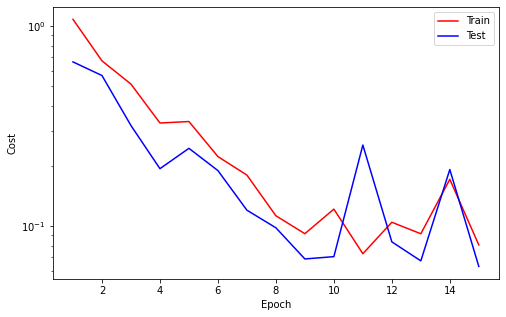

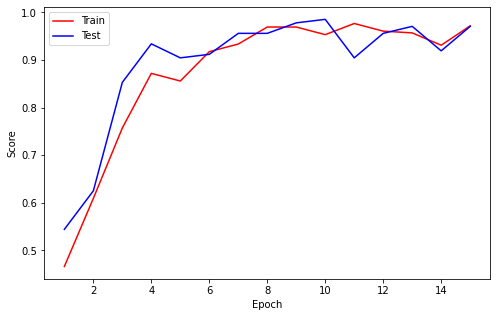

In [12]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    #logging
    callback.log(train_cost, test_cost, train_score, test_score)
    #checkpoint
    callback.save_checkpoint()
    #runtime plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    #early stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [13]:
feature, target = next(iter(testloader))
feature, target = feature.to(device),target.to(device)

In [14]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([3, 1, 3, 0, 3, 1, 0, 2, 0, 0, 3, 2, 2, 2, 1, 1, 0, 0, 1, 1])

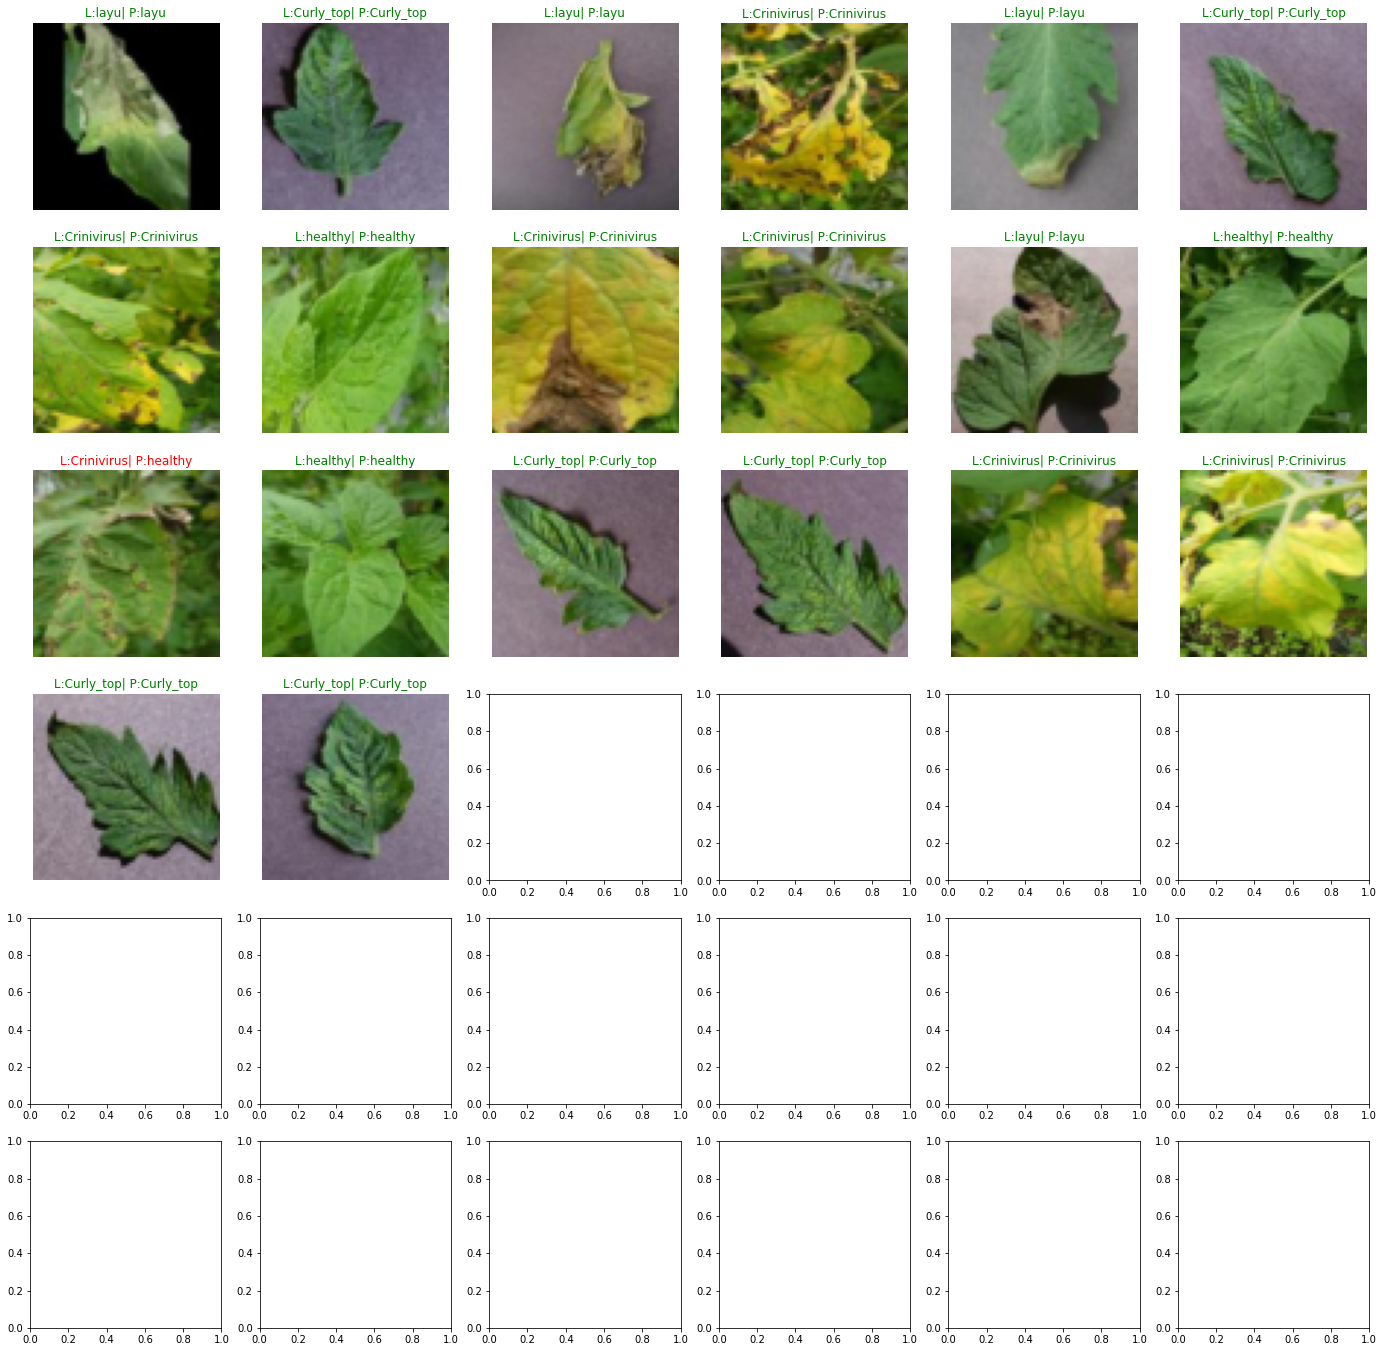

In [15]:
#VISUALISASI PREDIKSI PENYAKIT
fig, axes = plt.subplots(6,6,figsize=(24,24))
for image, label, pred, ax in zip(feature,target,preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L:{label}| P:{pred}", fontdict=font);
    ax.axis('off');